In [2]:
import random
import pandas as pd
import numpy as np
from datetime import datetime,timedelta
import math
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
orders=pd.read_csv('orders.csv')

In [4]:
# Оставим исходный файл в нетронутом состоянии
orders1=orders.copy()

In [5]:
orders1['order_date']=pd.to_datetime(orders['order_date'])
# Для удобства восприятия датафрейма вставим дату первой транзакции в удобное место
orders1.insert(2,'signup', orders1.groupby('customer_id')['order_date'].transform('min').dt.to_period('M'))


In [6]:
# Вычмслим размеры когорт
size_cohort=orders1.groupby('signup',as_index=False).agg(cnt_customer_in_cohort=('customer_id','nunique'))
size_cohort

,signup,cnt_customer_in_cohort
0,2020-01,298
1,2020-02,292
2,2020-03,310
3,2020-04,300
4,2020-05,311
5,2020-06,300
6,2020-07,306
7,2020-08,313
8,2020-09,302
9,2020-10,303


In [7]:
# Создадим промежуточную таблицу где сохраними те транзакции, которые произошли в течение 10 дней с момента первой покупки
prom_table=(orders1.query("(order_date-signup.dt.to_timestamp()).dt.days<10")
 .groupby(['signup','platform','category','customer_id'],as_index=False)
 .agg(amount_per_customer=('order_amount','sum'))

)
prom_table

,signup,platform,category,customer_id,amount_per_customer
0,2020-01,desktop,аккумуляторы,2,3940.48
1,2020-01,desktop,аккумуляторы,3,1614.05
2,2020-01,desktop,аккумуляторы,5,8202.62
3,2020-01,desktop,аккумуляторы,9,2204.61
4,2020-01,desktop,аккумуляторы,10,527.09
...,...,...,...,...,...
5140,2020-12,mobile,телефоны,3425,3708.16
5141,2020-12,mobile,телефоны,3427,559.05
5142,2020-12,mobile,телефоны,3434,233.01
5143,2020-12,mobile,телефоны,3436,6733.76


In [8]:
# Трансформируем в агрегатную таблицу с выходными данными по количеству уникальных клиентов в юните и средней величиной трат
raschet_unit=(prom_table.groupby(['signup','platform','category'],as_index=False)
 .agg(cnt_customer_per_unit=('customer_id','nunique'),avg_profit=('amount_per_customer',lambda x: round(x.mean())))
 
)
raschet_unit

,signup,platform,category,cnt_customer_per_unit,avg_profit
0,2020-01,desktop,аккумуляторы,50,3722
1,2020-01,desktop,аксессуары,52,4138
2,2020-01,desktop,наушники,44,4012
3,2020-01,desktop,телефоны,53,3959
4,2020-01,mobile,аккумуляторы,50,3665
...,...,...,...,...,...
91,2020-12,desktop,телефоны,49,3911
92,2020-12,mobile,аккумуляторы,52,4194
93,2020-12,mobile,аксессуары,55,4886
94,2020-12,mobile,наушники,44,4093


In [9]:
itog_table=pd.merge(size_cohort,raschet_unit,how='inner',left_on='signup',right_on='signup')
itog_table

,signup,cnt_customer_in_cohort,platform,category,cnt_customer_per_unit,avg_profit
0,2020-01,298,desktop,аккумуляторы,50,3722
1,2020-01,298,desktop,аксессуары,52,4138
2,2020-01,298,desktop,наушники,44,4012
3,2020-01,298,desktop,телефоны,53,3959
4,2020-01,298,mobile,аккумуляторы,50,3665
...,...,...,...,...,...,...
91,2020-12,297,desktop,телефоны,49,3911
92,2020-12,297,mobile,аккумуляторы,52,4194
93,2020-12,297,mobile,аксессуары,55,4886
94,2020-12,297,mobile,наушники,44,4093


In [10]:
itog_table['signup']=itog_table['signup'].astype(str)
itog_table.head(2)['cnt_customer_per_unit'].sum()

np.int64(102)

In [11]:
itog_table

,signup,cnt_customer_in_cohort,platform,category,cnt_customer_per_unit,avg_profit
0,2020-01,298,desktop,аккумуляторы,50,3722
1,2020-01,298,desktop,аксессуары,52,4138
2,2020-01,298,desktop,наушники,44,4012
3,2020-01,298,desktop,телефоны,53,3959
4,2020-01,298,mobile,аккумуляторы,50,3665
...,...,...,...,...,...,...
91,2020-12,297,desktop,телефоны,49,3911
92,2020-12,297,mobile,аккумуляторы,52,4194
93,2020-12,297,mobile,аксессуары,55,4886
94,2020-12,297,mobile,наушники,44,4093


In [12]:
# Соберем pivot таблицу для визуального табличного представления, о распределении среднего профита
pivot=itog_table.pivot_table(index='signup',columns=['platform','category'],values='avg_profit')
pivot

platform      desktop                                    mobile             \
category аккумуляторы аксессуары наушники телефоны аккумуляторы аксессуары   
signup                                                                       
2020-01        3722.0     4138.0   4012.0   3959.0       3665.0     3757.0   
2020-02        2903.0     3841.0   4161.0   4357.0       3657.0     3968.0   
2020-03        4146.0     3971.0   3971.0   4745.0       3927.0     4459.0   
2020-04        4164.0     4343.0   4594.0   3457.0       3815.0     3760.0   
2020-05        3480.0     3679.0   3651.0   4319.0       4337.0     4089.0   
2020-06        4097.0     4148.0   3704.0   3788.0       3895.0     3296.0   
2020-07        3666.0     4202.0   3243.0   4822.0       4083.0     3687.0   
2020-08        3866.0     4375.0   4840.0   3116.0       3663.0     4971.0   
2020-09        3915.0     4006.0   3800.0   3960.0       4359.0     3610.0   
2020-10        4199.0     4040.0   3365.0   4107.0       3589.0     3706.0   
2020-11        4263.0     4215.0   3986.0   3948.0       4695.0     4244.0   
2020-12        4281.0     3715.0   4815.0   3911.0       4194.0     4886.0   

platform                    
category наушники телефоны  
signup                      
2020-01    4405.0   3858.0  
2020-02    3504.0   4201.0  
2020-03    4220.0   4309.0  
2020-04    3777.0   3326.0  
2020-05    4172.0   4449.0  
2020-06    3884.0   4796.0  
2020-07    3722.0   3832.0  
2020-08    4309.0   4391.0  
2020-09    4100.0   4153.0  
2020-10    4631.0   4757.0  
2020-11    4076.0   3976.0  
2020-12    4093.0   4702.0

In [13]:
# Соберем таблицу для визуального размера когорт и среднего профита в контексте  10-ти дневного среза транзакций
visual=itog_table.groupby(['signup','cnt_customer_in_cohort','platform'])['avg_profit'].mean().reset_index()

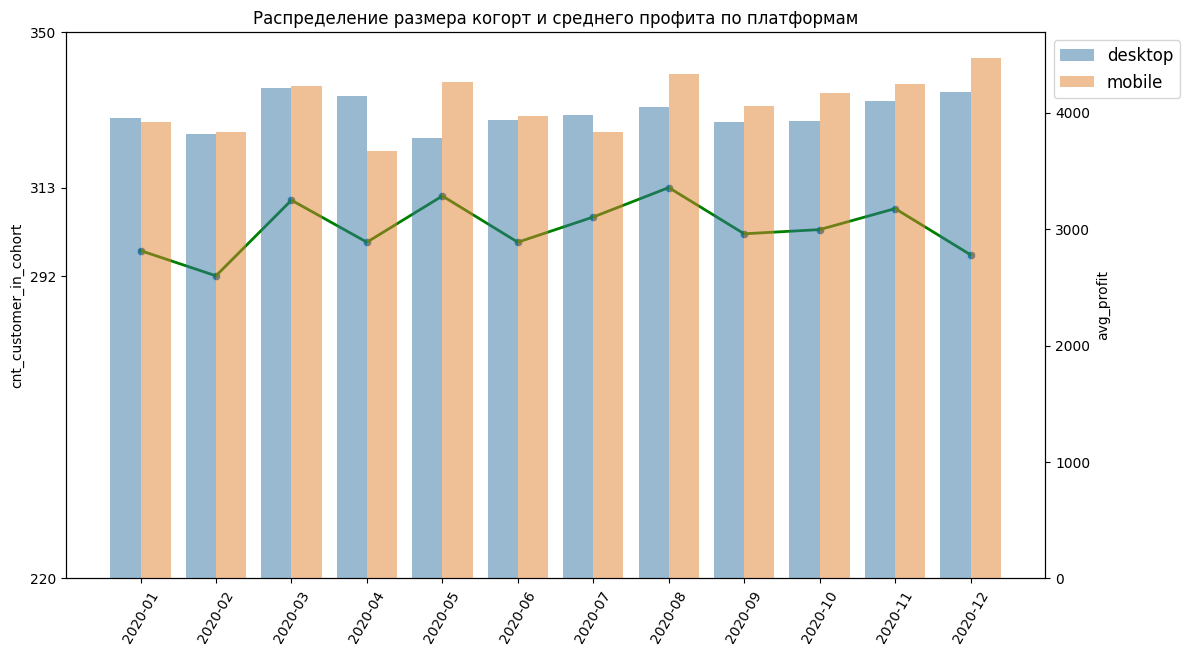

In [14]:
fg,ax=plt.subplots(figsize=(12,6))
ax1=ax.twinx()
sns.barplot(ax=ax1,data=visual,x='signup',y='avg_profit',hue='platform',alpha=0.5)
ax1.legend(loc='best', bbox_to_anchor=(1, 1), fontsize=12)
sns.lineplot(ax=ax, data=size_cohort, x=np.arange(0,12,1).tolist(), y='cnt_customer_in_cohort',lw=2,color='green')
plt.tight_layout()
sns.scatterplot(ax=ax, data=size_cohort, x=np.arange(0,12,1).tolist(), y='cnt_customer_in_cohort')
ax.set_yticks([220,size_cohort['cnt_customer_in_cohort'].min(),size_cohort['cnt_customer_in_cohort'].max(),350])
ax.tick_params(axis='x', rotation=60)  
plt.title('Распределение размера когорт и среднего профита по платформам');






In [15]:
raschet_unit1=(prom_table.groupby(['signup','platform','category'],as_index=False)
 .agg(profit=('amount_per_customer',lambda x: round(x.sum())))
 
)
itog_table1=pd.merge(size_cohort,raschet_unit1,how='inner',left_on='signup',right_on='signup')
itog_table1['signup']=itog_table1['signup'].astype(str)
itog_table1

,signup,cnt_customer_in_cohort,platform,category,profit
0,2020-01,298,desktop,аккумуляторы,186104
1,2020-01,298,desktop,аксессуары,215162
2,2020-01,298,desktop,наушники,176508
3,2020-01,298,desktop,телефоны,209835
4,2020-01,298,mobile,аккумуляторы,183256
...,...,...,...,...,...
91,2020-12,297,desktop,телефоны,191648
92,2020-12,297,mobile,аккумуляторы,218095
93,2020-12,297,mobile,аксессуары,268710
94,2020-12,297,mobile,наушники,180092


In [16]:
mosaik=[['A','C','B']]

''

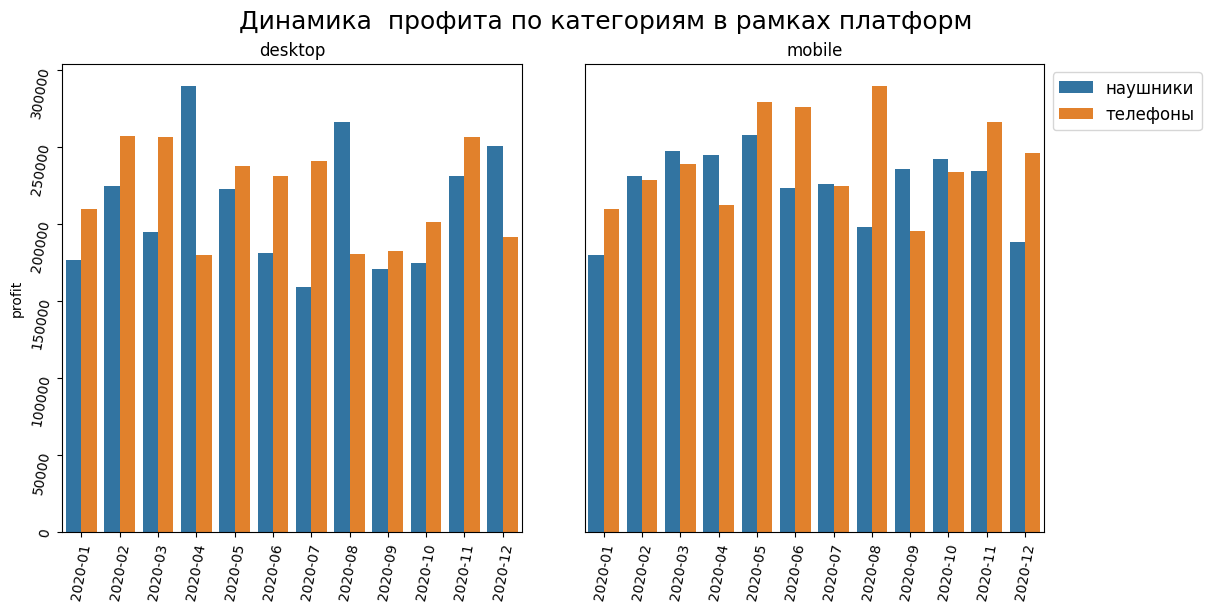

In [17]:
fig1,ax=plt.subplot_mosaic(mosaic=mosaik,figsize=(12,6),layout="constrained",width_ratios=[1,0.1,1])
fig1.suptitle('Динамика  профита по категориям в рамках платформ',fontsize=18)

sns.barplot(ax=ax['A'],data=itog_table1.query("platform == 'desktop' and category in ('телефоны','наушники')"),x='signup',y='profit',hue='category',legend=False)
ax['A'].tick_params(rotation=80)
ax['A'].set_xlabel(None)
ax['A'].set_title('desktop')

sns.barplot(ax=ax['B'],data=itog_table1.query("platform == 'mobile' and category in ('телефоны','наушники')"),x='signup',y='profit',hue='category')
ax['B'].tick_params(rotation=80)
ax['B'].legend(loc='best', bbox_to_anchor=(1, 1), fontsize=12)
ax['B'].set_ylabel(None)
ax['B'].set_yticks([])
ax['B'].set_xlabel(None)
ax['B'].set_title('mobile')


ax['C'].set_frame_on(False)
ax['C'].set_yticks([])
ax['C'].set_xticks([])

;